Calculate TPR from measured PDD. The PDDs were measured at 100cm FSD, so the field size is set at the surface, and dref is 5cm

Reproduce work that used VBA. Note that data is loaded as string, so have to be carefulf to convert to floats.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

import statsmodels.api as sm
from statsmodels import regression

## Load the PDD data

In [2]:
PDD = pd.read_table('PDD_6MV.csv', sep= ",", index_col=0)#.astype(np.float); # Load the PDD, convert strings to floats

In [3]:
PDD.index = PDD.index.map(int)       # index and columns are ints for convenience later
PDD.columns = PDD.columns.map(int)   # map values to floats 

PDD.index.rename('Depth_mm', inplace=True)  # rename the cols and index
PDD.columns.rename('Fields_mm', inplace=True)

In [4]:
PDD.head()

Fields_mm,10,20,30,40,50,60,70,80,100,120,150,200,250,300,400
Depth_mm,,,,,,,,,,,,,,,
0,42.0,43.0,44.8,45.3,46.6,47.3,48.7,49.0,50.8,51.9,54.6,58.6,62.3,65.3,69.3
1,49.0,50.0,50.4,50.7,52.0,52.8,54.2,54.4,56.3,56.8,59.5,63.4,66.9,69.8,73.5
2,56.0,57.0,58.6,58.7,60.3,60.9,61.8,62.4,64.1,64.1,66.7,70.1,73.2,75.8,79.1
3,66.2,67.2,68.2,67.9,69.6,70.2,70.3,71.4,72.8,72.5,74.7,77.7,80.2,82.3,84.8
4,74.8,75.8,76.8,76.4,77.8,78.3,78.1,79.3,80.4,80.1,81.8,84.1,86.1,87.7,89.5


In [5]:
#PDD.tail()

In [6]:
PDD.shape

(352, 15)

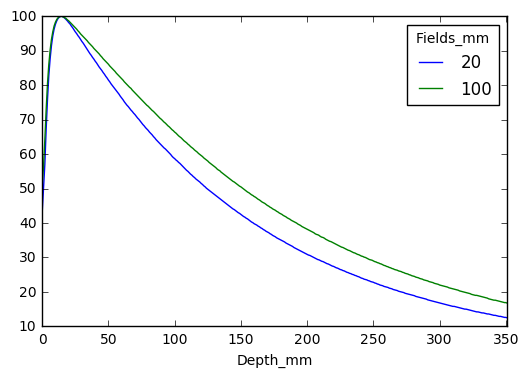

In [7]:
PDD[[20,100]].plot()

# Get PDD for field/depth programatically using 2D interp

In [8]:
fields = PDD.columns.values.astype(np.float)
depths = PDD.index.values.astype(np.float)

PDDInterp = interpolate.interp2d(fields, depths, PDD.as_matrix(), kind='linear')  # create the 2D interp

def PDD_(field, depth):  # helper function to get a pdd
    return PDDInterp(field, depth).item()

PDD_(field = 25, depth = 3.5)

72.0

## Load normalised PSF and get for any field size

Note that only have field sizes 10 - 400 mm but later will need field sizes outside of this range so have to do a polynomial fit out of this range

In [9]:
# Get the NPSF data
NPSF_np = np.genfromtxt('NPSF.csv', delimiter= ",")
Fields_NPSF = NPSF_np[0][1:]
NPSF = NPSF_np[1][1:]

#plt.plot(Fields_NPSF,NPSF)

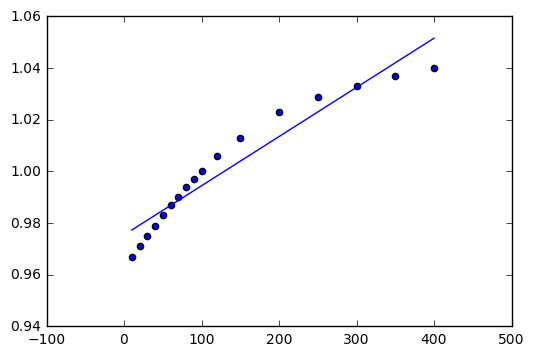

In [10]:
# Linear regression no good
x = Fields_NPSF
y = NPSF
X = sm.add_constant(x)

model = regression.linear_model.OLS(y, X).fit()
intercept = model.params[0]
slope = model.params[1]

y2 = intercept + slope*x
plt.scatter(x,y)
plt.plot(x,y2)

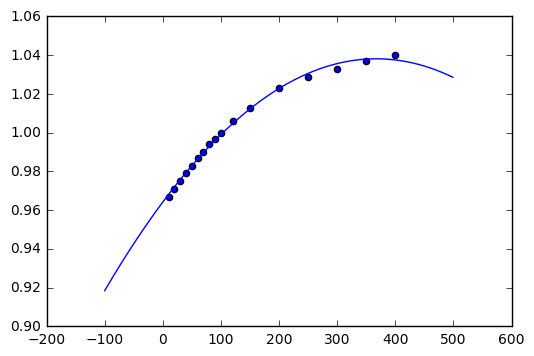

In [11]:
z = np.polyfit(x, y, deg = 2)   # do the poly fit, z is a list of the fit coefficients
p = np.poly1d(z)                # get a polyfit object, pass this an x to get the y

plt.scatter(x,y)

xnew = np.arange(-100, 500)
plt.plot(xnew,p(xnew))

In [12]:
p(44.23)

0.98094656991329787

In [13]:
NPSF_ = p    # just reassign as used later

# Calculated TPR

For a given field, depth and reference depth, calulate the TPR

In [14]:
def TPR(field_mm, depth_mm, depth_ref_mm):   # copied straigth from EXCEL
    # 'Calculate TPR for SSD f = 100cm'
    f = 1000.0   # The SSD under ref conditions, 100 cm
    S = field_mm
    d = depth_mm
    dr = depth_ref_mm
    correction = ((f + d) / (f + dr)) ** 2
    PDD_d = PDD_(((S * f) / (f + d)), d)
    PDD_dr = PDD_(((S * f) / (f + dr)), dr)
    NPSF_d = NPSF_(((S * f) / (f + d)))
    NPSF_dr = NPSF_(((S * f) / (f + dr)))
    TPR = (PDD_d / PDD_dr) * (NPSF_d / NPSF_dr) * correction
    return TPR

depth_ref_mm = 50.0 # the reference depth, cm
depth_mm = 100.0 # the depth to calculate TPR, cm
field_mm = 100.0  # calc for single field size, at surface under ref conditions
print(TPR(field_mm, depth_mm, depth_ref_mm))   # 0.84 agrees with EXCEL calcs

0.839737607403


In [15]:
print(TPR(field_mm = 5, depth_mm = 0 , depth_ref_mm = 350.0))   # working at extremes OK

1.987722218


# Generate TPR table

As with my project work I had to iterate over the data frame to apply the funciton taking in index/column values

In [16]:
fields = PDD.columns.values.astype(np.float)
depths = PDD.index.values.astype(np.float)

columns = len(fields)
rows = len(depths)
TPR_array = np.zeros((rows,columns))  # init an empty array

In [17]:
TPR_array.shape

(352, 15)

In [18]:
row = 0
for depth in depths:
    column = 0
    for field in fields:
        TPR_array[row][column] = TPR(field, depth, depth_ref_mm)
        column = column + 1
    row = row + 1  

In [19]:
TPR_df = pd.DataFrame(data=TPR_array, index=depths, columns=fields)  # 1st row as the column names

In [24]:
TPR_df.index.name = 'Depth_mm'
TPR_df.columns.name = 'Field_size'

In [25]:
TPR_df.head()

Field_size,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,100.0,120.0,150.0,200.0,250.0,300.0,400.0
Depth_mm,,,,,,,,,,,,,,,
0.0,0.473324,0.479294,0.492641,0.493322,0.503412,0.507448,0.519434,0.520915,0.536804,0.545789,0.570494,0.609614,0.646427,0.674691,0.711334
1.0,0.553314,0.558408,0.555311,0.553212,0.562791,0.567524,0.579136,0.579448,0.595995,0.598463,0.622773,0.660682,0.695342,0.722434,0.755813
2.0,0.633621,0.637833,0.646852,0.641782,0.653822,0.655864,0.661633,0.665890,0.679837,0.676742,0.699392,0.731832,0.762197,0.785958,0.814928
3.0,0.750523,0.753453,0.754340,0.743888,0.756078,0.757489,0.754251,0.763270,0.773610,0.766986,0.784773,0.812705,0.836690,0.855001,0.875391
4.0,0.849711,0.851552,0.851127,0.838695,0.846833,0.846560,0.839675,0.849294,0.856064,0.849063,0.861070,0.881392,0.900009,0.912919,0.925795


In [26]:
TPR_df.to_csv('Pandas_TPR.csv')

Looks identical to the table calculated in Excel